In [18]:
import os
import pandas as pd
import numpy as np

In [19]:
def load_data(data_dir):
    all_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith(".csv")]

    dataframes = []

    for file_name in all_files:
        # Extract the timestamp from the filename
        timestamp = file_name.split("/")[-1].split(".")[0]
        start_time = pd.to_datetime(timestamp, format='%Y%m%d_%H%M%S')

        df = pd.read_csv(file_name, sep=",")
        df['datetime'] = start_time + pd.to_timedelta(df['Time (s)'], unit='s')
        dataframes.append(df)

    merged_data = pd.concat(dataframes, ignore_index=True)
    merged_data.set_index('datetime', inplace=True)
    return merged_data[[col for col in merged_data.columns if 'R' in col]]

In [20]:
df = load_data("/content/drive/MyDrive/anomaly detection/gas-data/")
df = df.sort_index()
df.head()

,R1 (MOhm),R2 (MOhm),R3 (MOhm),R4 (MOhm),R5 (MOhm),R6 (MOhm),R7 (MOhm),R8 (MOhm),R9 (MOhm),R10 (MOhm),R11 (MOhm),R12 (MOhm),R13 (MOhm),R14 (MOhm)
datetime,,,,,,,,,,,,,,
2016-10-03 08:56:24.000,0.5114,0.5863,0.5716,1.9386,1.1669,0.7103,0.5541,51.0146,40.8079,47.8748,4.6007,1.0259,0.6300,0.4302
2016-10-03 08:56:24.311,0.0626,0.1586,0.1161,0.1347,0.1385,0.1545,0.1307,0.1935,0.1341,0.1773,0.1403,0.1399,0.1243,0.1236
2016-10-03 08:56:24.620,0.0654,0.1496,0.1075,0.1076,0.1131,0.1363,0.1188,0.1195,0.1049,0.1289,0.1189,0.1216,0.1106,0.1130
2016-10-03 08:56:24.930,0.0722,0.1444,0.1074,0.1032,0.1106,0.1306,0.1190,0.1125,0.1014,0.1232,0.1153,0.1185,0.1091,0.1114
2016-10-03 08:56:25.238,0.0767,0.1417,0.1098,0.1025,0.1116,0.1284,0.1208,0.1111,0.1008,0.1226,0.1140,0.1175,0.1090,0.1111


In [21]:
df.shape

(1478086, 14)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Set a threshold for high correlation
threshold = 0.9

# Identify columns to drop
drop_columns = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:  # High correlation
            colname = corr_matrix.columns[i]
            if colname not in drop_columns:
                drop_columns.append(colname)

# Drop the highly correlated columns
data_dropped = df.drop(columns=drop_columns)

print("Columns dropped due to high correlation:", drop_columns)

Columns dropped due to high correlation: ['R2 (MOhm)', 'R3 (MOhm)', 'R5 (MOhm)', 'R6 (MOhm)', 'R7 (MOhm)', 'R9 (MOhm)', 'R10 (MOhm)', 'R11 (MOhm)', 'R12 (MOhm)', 'R13 (MOhm)', 'R14 (MOhm)']


In [24]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = data_dropped.columns
scaled_data = data_dropped.copy()
scaler = StandardScaler()
scaled_data[columns_to_scale] = scaler.fit_transform(data_dropped[columns_to_scale])

In [25]:
scaled_data.head()

,R1 (MOhm),R4 (MOhm),R8 (MOhm)
datetime,,,
2016-10-03 08:56:24.000,-0.675302,-1.120055,1.084457
2016-10-03 08:56:24.311,-0.693799,-1.222210,-1.349995
2016-10-03 08:56:24.620,-0.693684,-1.223745,-1.353539
2016-10-03 08:56:24.930,-0.693403,-1.223994,-1.353875
2016-10-03 08:56:25.238,-0.693218,-1.224034,-1.353942


---
**Z-SCORES**

Number of outliers per column:
R1 (MOhm)    11436
R4 (MOhm)      887
R8 (MOhm)      303
dtype: int64


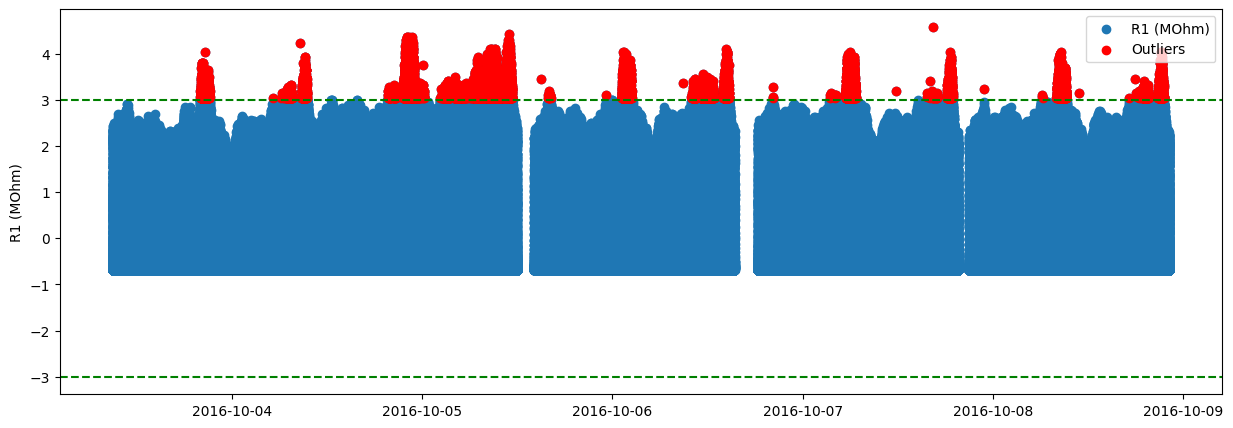

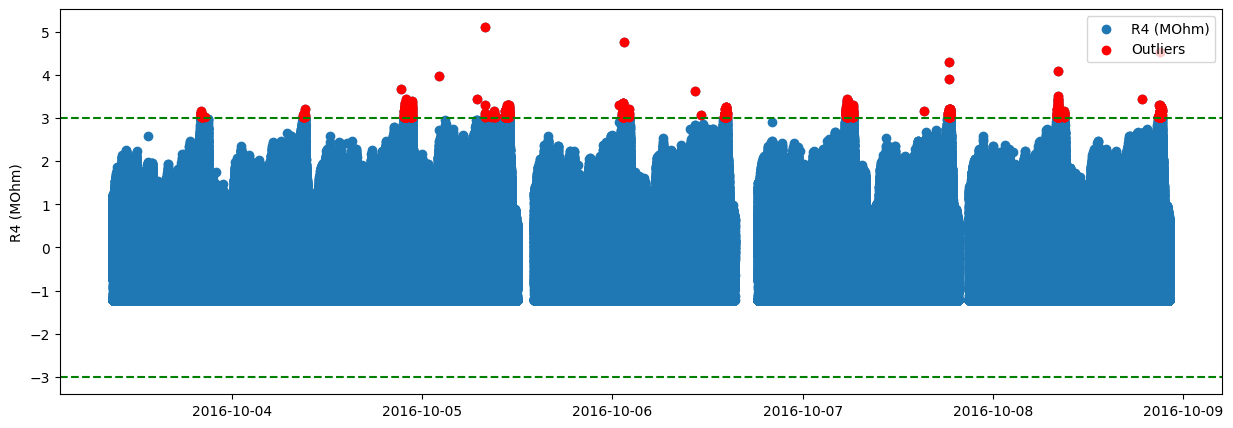

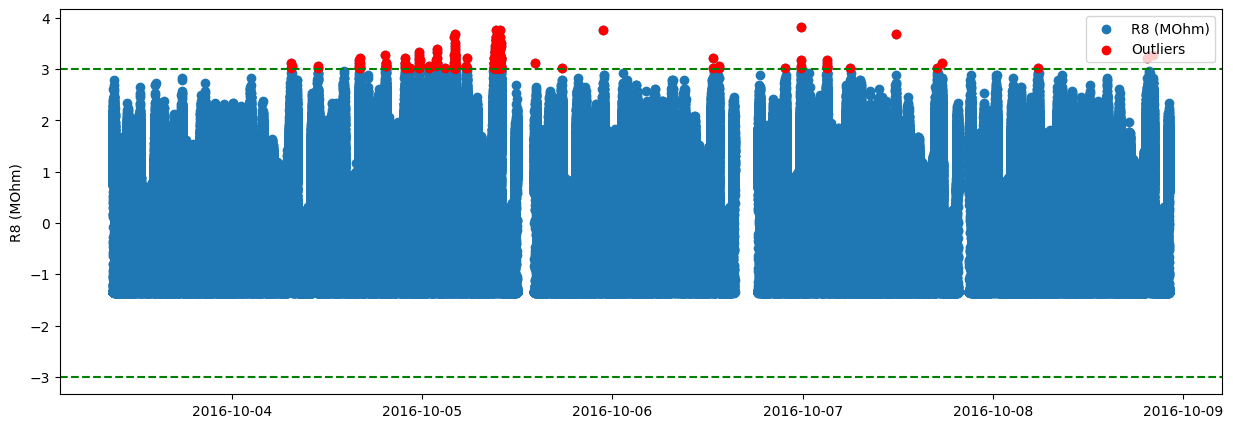

In [26]:
# Detect outliers using Z-score
from scipy.stats import zscore

# Calculate Z-scores
z_scores = scaled_data.apply(zscore)
outliers = (z_scores.abs() > 3).sum()

print("Number of outliers per column:")
print(outliers)

for col in data_dropped.columns:
    plt.figure(figsize=(15, 5))
    plt.scatter(scaled_data.index, scaled_data[col], label=col)
    plt.scatter(scaled_data.index[z_scores[col].abs() > 3], scaled_data[col][z_scores[col].abs() > 3], color="red", label="Outliers")
    plt.axhline(y=3, color='green', linestyle='--')
    plt.axhline(y=-3, color='green', linestyle='--')
    plt.ylabel(col)
    plt.legend(loc="upper right")
plt.show()

---
**ISOLATION FORESTS**

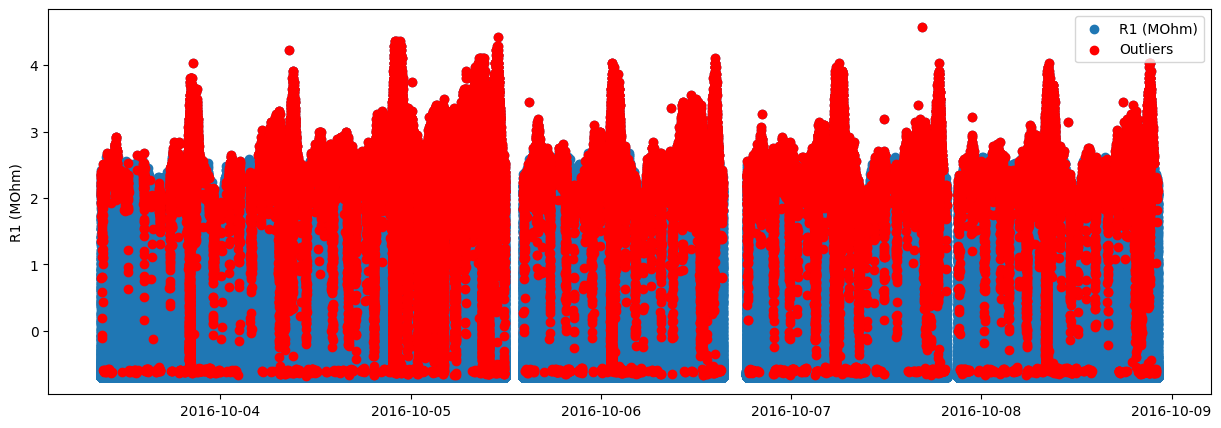

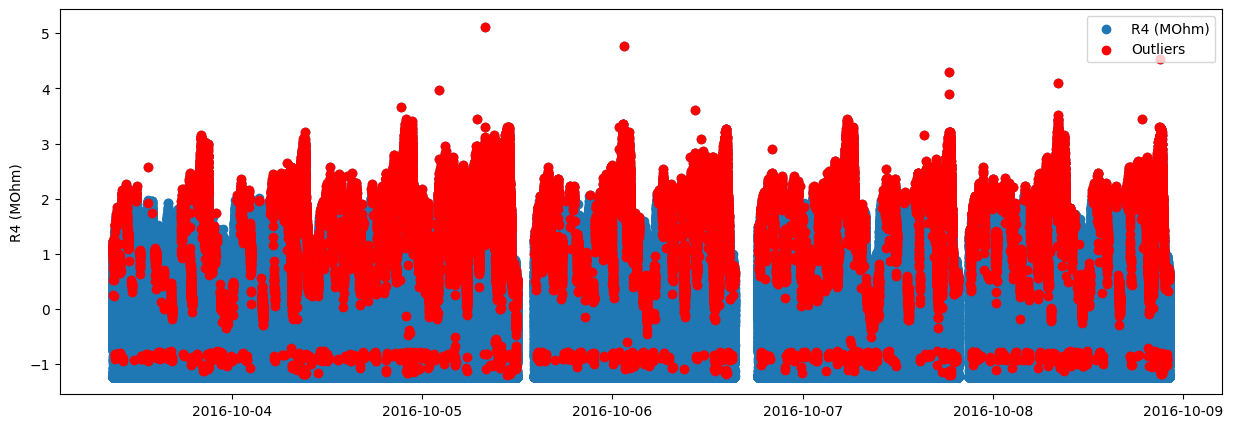

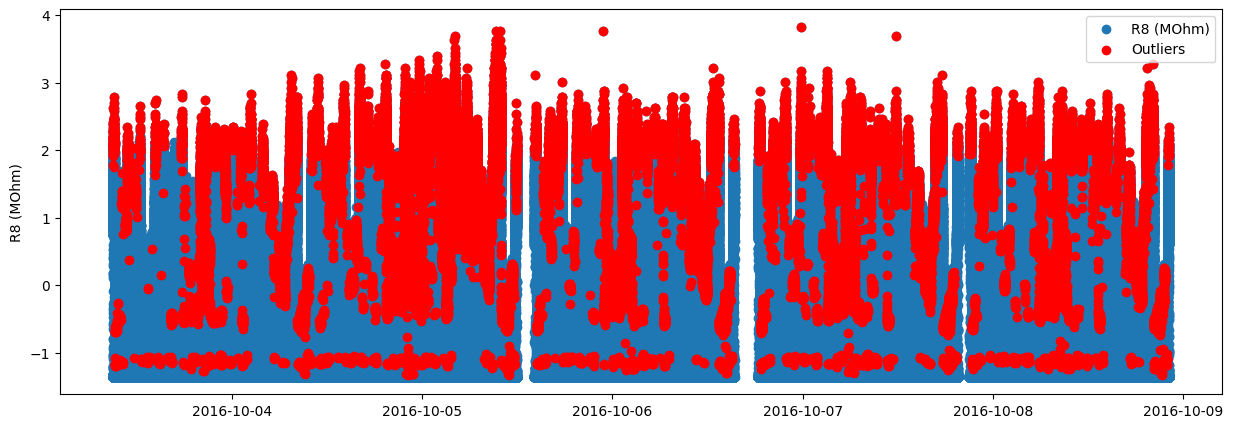

Number of anomalies detected: 73905


In [27]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.05, random_state=42)
model.fit(scaled_data)
predictions = model.predict(scaled_data)

# Convert predictions to a DataFrame (same index as original data)
outliers = pd.Series(predictions, index=data_dropped.index)

for col in data_dropped.columns:
    plt.figure(figsize=(15, 5))
    plt.scatter(scaled_data.index, scaled_data[col], label=col)
    plt.scatter(scaled_data.index[outliers == -1], scaled_data[col][outliers == -1], color="red", label="Outliers")
    plt.ylabel(col)
    plt.legend(loc="upper right")
    plt.show()

# Print the number of detected anomalies
print(f'Number of anomalies detected: {outliers[outliers == -1].shape[0]}')

---
**AUTOENCODER**

In [28]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

train_size = int(len(scaled_data) * 0.8)

X_train = scaled_data[:train_size]
X_test = scaled_data[train_size:]

autoencoder = Sequential()

# Encoder
autoencoder.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(32, activation='relu'))

# Decoder
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(128, activation='relu'))
autoencoder.add(Dense(X_train.shape[1], activation='linear'))

autoencoder.compile(optimizer=Adam(), loss='mse')
autoencoder.fit(X_train, X_train, epochs=10, batch_size=256, validation_data=(X_test, X_test), verbose=1)

Epoch 1/10
4620/4620 [==============================] - 16s 3ms/step - loss: 0.0030 - val_loss: 4.3141e-04
Epoch 2/10
4620/4620 [==============================] - 14s 3ms/step - loss: 4.6834e-05 - val_loss: 3.6802e-04
Epoch 3/10
4620/4620 [==============================] - 14s 3ms/step - loss: 3.5785e-05 - val_loss: 6.9385e-06
Epoch 4/10
4620/4620 [==============================] - 14s 3ms/step - loss: 3.0851e-05 - val_loss: 2.2696e-04
Epoch 5/10
4620/4620 [==============================] - 14s 3ms/step - loss: 2.9593e-05 - val_loss: 9.4888e-05
Epoch 6/10
4620/4620 [==============================] - 14s 3ms/step - loss: 2.4364e-05 - val_loss: 4.4071e-05
Epoch 7/10
4620/4620 [==============================] - 15s 3ms/step - loss: 2.4394e-05 - val_loss: 1.3315e-04
Epoch 8/10
4620/4620 [==============================] - 16s 3ms/step - loss: 2.1656e-05 - val_loss: 1.0072e-05
Epoch 9/10
4620/4620 [==============================] - 15s 3ms/step - loss: 2.0878e-05 - val_loss: 5.1525e-04
Epoch

In [29]:
# reconstruct the test data
reconstructed = autoencoder.predict(X_test)

# reconstruction error
mse = np.mean(np.power(X_test - reconstructed, 2), axis=1)

# threshold for anomalies
threshold = np.percentile(mse, 95)  # 95th percentile as threshold

# detect anomalies (1: normal, -1: anomaly)
anomalies = mse > threshold

9239/9239 [==============================] - 12s 1ms/step


In [30]:
print(f'Number of anomalies detected: {np.sum(anomalies)}')

Number of anomalies detected: 14781


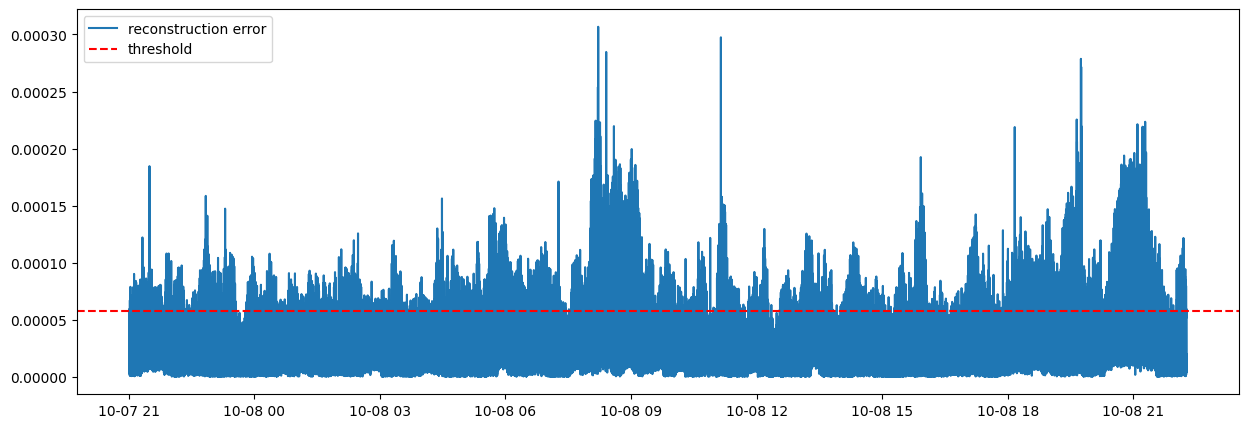

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(mse, label='reconstruction error')
plt.axhline(y=threshold, color='r', linestyle='--', label="threshold")
plt.legend()
plt.show()

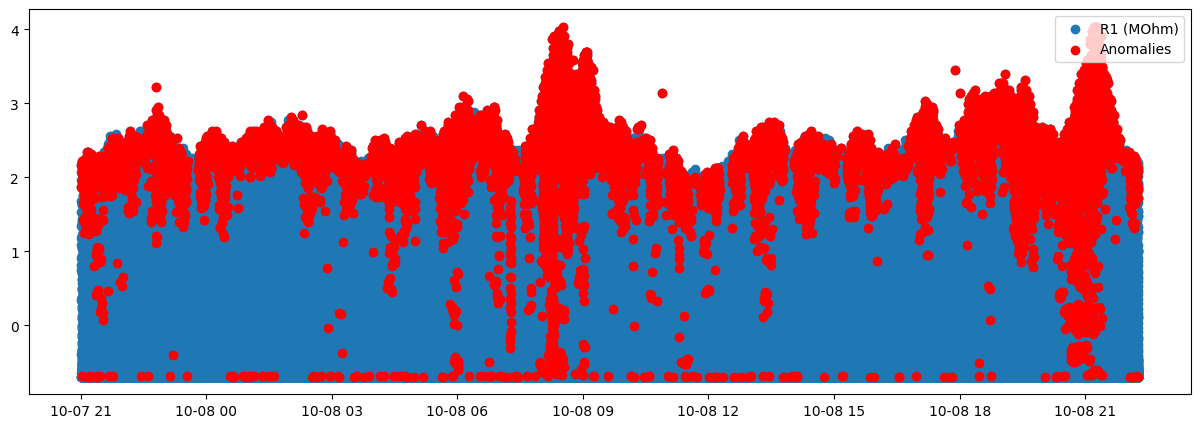

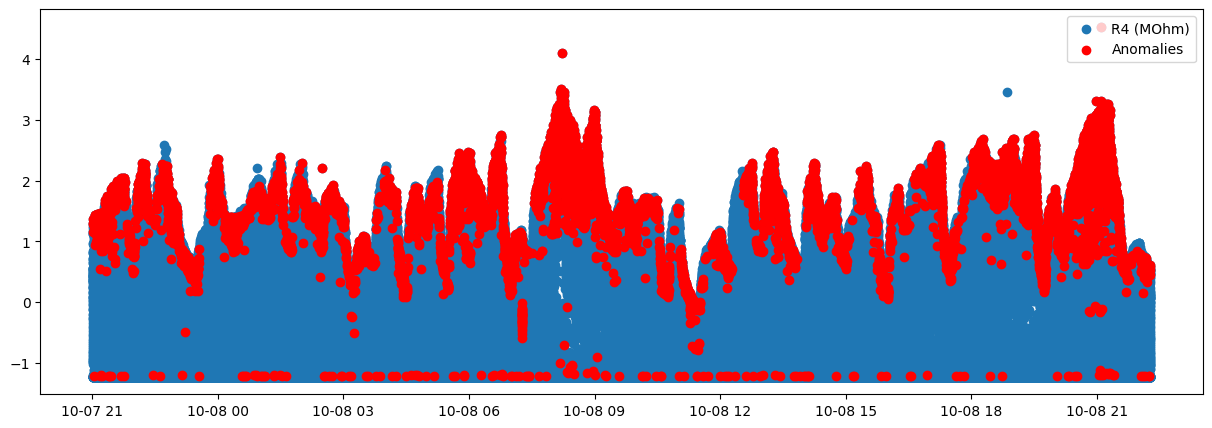

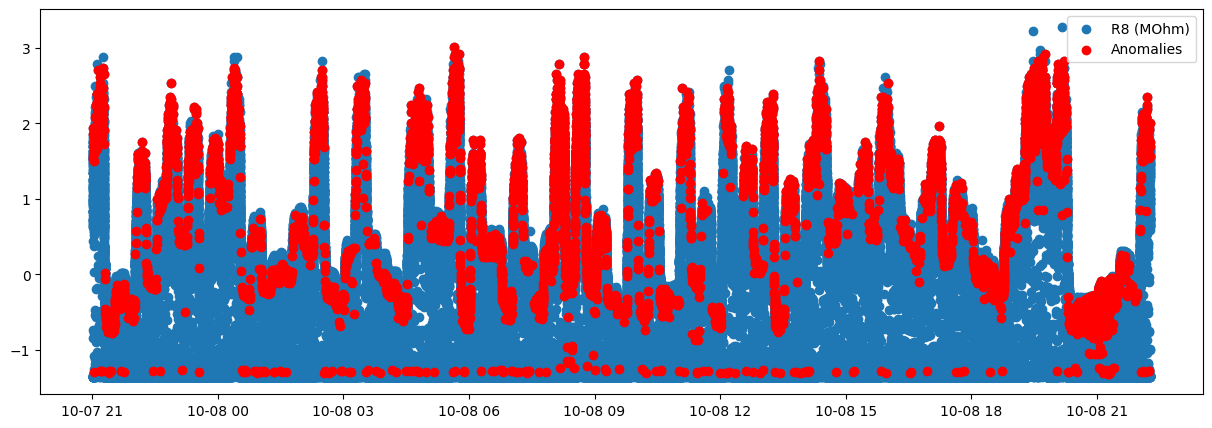

In [32]:
for col in X_test.columns:
    plt.figure(figsize=(15, 5))
    plt.scatter(X_test.index, X_test[col], label=col)
    plt.scatter(X_test.index[anomalies], X_test[col][anomalies], color="red", label="Anomalies")
    plt.legend(loc="upper right")
    plt.show()

---
**LSTM-AUTOENCODER MODEL**

In [33]:
timesteps = 60
n_features = scaled_data.shape[1]

def create_sequences(data, timesteps):
    for i in range(timesteps, len(data)):
        yield data[i-timesteps:i]

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

train_sequences = np.array(list(create_sequences(train_data, timesteps)))
test_sequences = np.array(list(create_sequences(test_data, timesteps)))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

input_layer = Input(shape=(timesteps, n_features))

# Encoder
encoded = LSTM(64, activation='relu', return_sequences=False)(input_layer)
encoded = RepeatVector(timesteps)(encoded)

# Decoder
decoded = LSTM(64, activation='relu', return_sequences=True)(encoded)
decoded = TimeDistributed(Dense(n_features))(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# train
autoencoder.fit(train_sequences, train_sequences,
                epochs=10,
                batch_size=256,
                validation_data=(test_sequences, test_sequences))


Epoch 1/10
 369/4619 [=>............................] - ETA: 11:13 - loss: 0.6795

In [ ]:
# reconstruction errors
train_pred = autoencoder.predict(train_sequences, batch_size=256)
test_pred = autoencoder.predict(test_sequences, batch_size=256)

train_loss = np.mean(np.abs(train_pred - train_sequences), axis=(1, 2))
test_loss = np.mean(np.abs(test_pred - test_sequences), axis=(1, 2))

# threshold
threshold = np.percentile(train_loss, 95)

test_anomalies = test_loss > threshold

In [ ]:
print(f"Number of anomalies: {np.sum(test_anomalies)}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_loss, label='Test Loss')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(test_anomalies)[0], test_loss[test_anomalies], color='r', label='Anomalies')
plt.legend()
plt.show()